In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
column_name = ' SM_50cm'
# Load the data
file_path = 'DATASET_4_ans.csv'
df = pd.read_csv(file_path, sep=';')
df.head()

,Year,Month,Day,Hour,Minute,TAir,Precip1,SM_5cm,ST_5cm,SM_10cm,ST_10cm,SM_20cm,ST_20cm,SM_50cm,ST_50cm
0,2014.0,5.0,30.0,12.0,0.0,16.6,0.0,0.188,19.1,0.148,18.8,0.123,18.0,0.165,17.3
1,2014.0,5.0,30.0,13.0,0.0,17.7,0.0,0.187,19.7,0.150,19.5,0.122,18.0,0.164,17.3
2,2014.0,5.0,30.0,14.0,0.0,18.9,0.0,0.187,20.7,0.150,20.3,0.126,18.4,0.165,17.3
3,2014.0,5.0,30.0,15.0,0.0,19.5,0.0,0.186,20.7,0.158,21.1,0.120,18.6,0.167,17.3
4,2014.0,5.0,30.0,16.0,0.0,20.1,0.0,0.183,20.7,0.161,21.1,0.125,19.1,0.167,17.3


In [3]:
df = df[['Year', 'Month', 'Day', 'Hour', 'Minute', column_name]]

In [4]:
df.dropna(inplace=True)

In [5]:
from prophet import Prophet

In [6]:
df.head()

,Year,Month,Day,Hour,Minute,SM_50cm
0,2014.0,5.0,30.0,12.0,0.0,0.165
1,2014.0,5.0,30.0,13.0,0.0,0.164
2,2014.0,5.0,30.0,14.0,0.0,0.165
3,2014.0,5.0,30.0,15.0,0.0,0.167
4,2014.0,5.0,30.0,16.0,0.0,0.167


In [7]:
df['ds'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
df.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1, inplace=True)
df.rename(columns={column_name: 'y'}, inplace=True)
df = df[['ds', 'y']]
df.set_index('ds', inplace=True)
df.head()

,y
ds,
2014-05-30 12:00:00,0.165
2014-05-30 13:00:00,0.164
2014-05-30 14:00:00,0.165
2014-05-30 15:00:00,0.167
2014-05-30 16:00:00,0.167


In [8]:
df = df.resample('h').interpolate()

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['y'] = scaler.fit_transform(df[['y']])
df.reset_index(inplace=True)

In [11]:
train_df =df[:int(0.9 * len(df))]
test_df = df[int(0.9 * len(df)):]
len(train_df), len(test_df)

(36212, 4024)

In [12]:
train_df.tail()

,ds,y
36207,2018-07-17 03:00:00,0.327488
36208,2018-07-17 04:00:00,0.327397
36209,2018-07-17 05:00:00,0.327306
36210,2018-07-17 06:00:00,0.327215
36211,2018-07-17 07:00:00,0.327124


In [13]:
test_df.head()

,ds,y
36212,2018-07-17 08:00:00,0.327033
36213,2018-07-17 09:00:00,0.326942
36214,2018-07-17 10:00:00,0.326851
36215,2018-07-17 11:00:00,0.326761
36216,2018-07-17 12:00:00,0.326670


In [14]:
m = Prophet()
m.fit(train_df)

12:33:29 - cmdstanpy - INFO - Chain [1] start processing
12:33:48 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
future = test_df[['ds']]
future.head()

,ds
36212,2018-07-17 08:00:00
36213,2018-07-17 09:00:00
36214,2018-07-17 10:00:00
36215,2018-07-17 11:00:00
36216,2018-07-17 12:00:00


In [16]:
forecast = m.predict(future)

In [17]:
forecast['yhat'].head()

0    0.505138
1    0.504588
2    0.504153
3    0.504184
4    0.504659
Name: yhat, dtype: float64

In [18]:
test_df.loc[:, 'yhat'] = forecast['yhat'].values
test_df.head()

/var/folders/4c/r5vs14757v7f8q75kdfzk0j00000gn/T/ipykernel_12757/2773033742.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:, 'yhat'] = forecast['yhat'].values


,ds,y,yhat
36212,2018-07-17 08:00:00,0.327033,0.505138
36213,2018-07-17 09:00:00,0.326942,0.504588
36214,2018-07-17 10:00:00,0.326851,0.504153
36215,2018-07-17 11:00:00,0.326761,0.504184
36216,2018-07-17 12:00:00,0.326670,0.504659


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [20]:
mse = mean_squared_error(test_df['y'], test_df['yhat'])

print(f"MSE: {mse}")

MSE: 0.48877623991920394


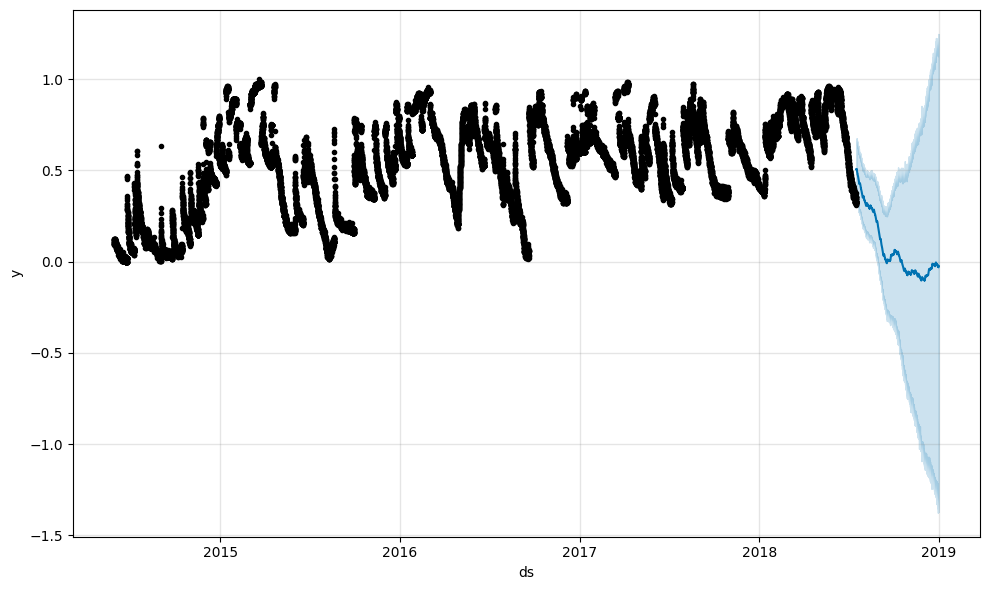

In [21]:
fig1 = m.plot(forecast)

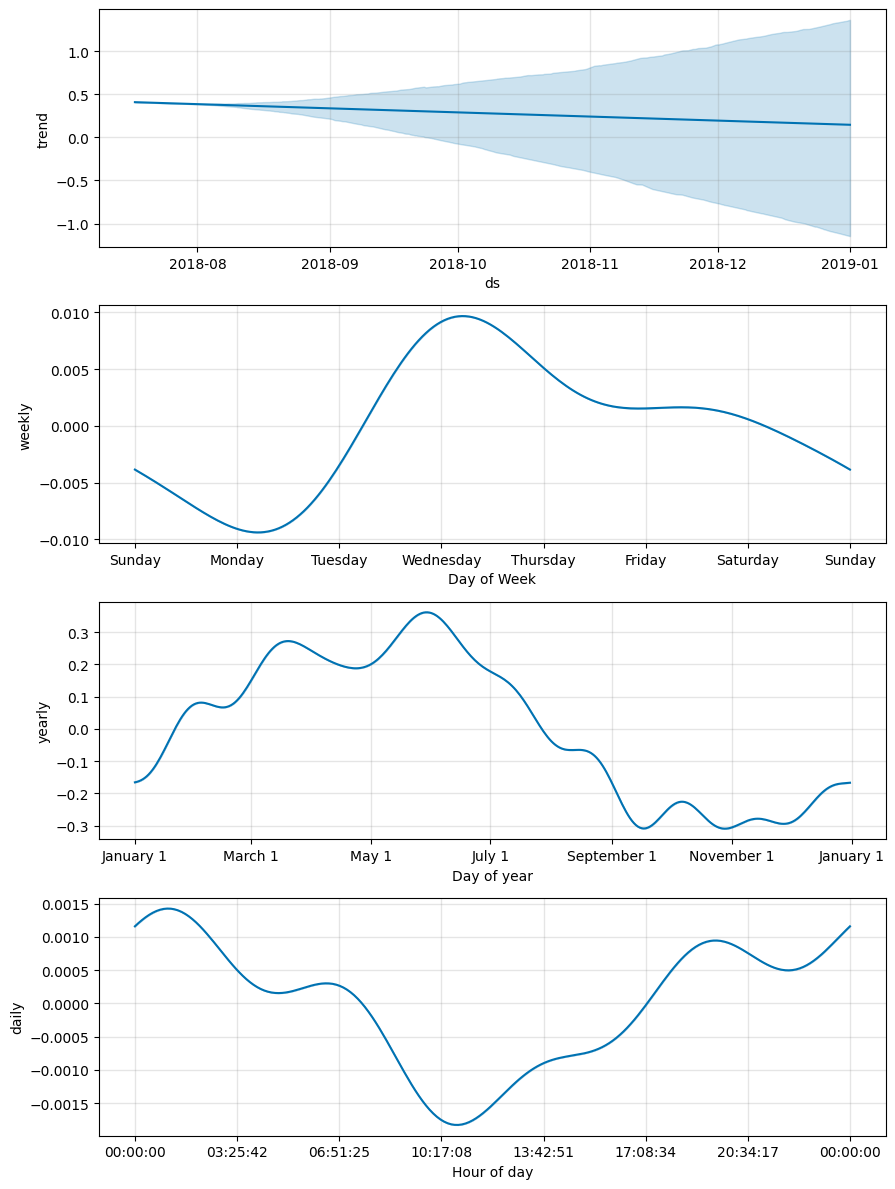

In [22]:
fig2 = m.plot_components(forecast)

In [23]:
comparison_df = test_df.merge(forecast[['ds', 'yhat']], on='ds',how='left')
comparison_df.head()

,ds,y,yhat_x,yhat_y
0,2018-07-17 08:00:00,0.327033,0.505138,0.505138
1,2018-07-17 09:00:00,0.326942,0.504588,0.504588
2,2018-07-17 10:00:00,0.326851,0.504153,0.504153
3,2018-07-17 11:00:00,0.326761,0.504184,0.504184
4,2018-07-17 12:00:00,0.326670,0.504659,0.504659


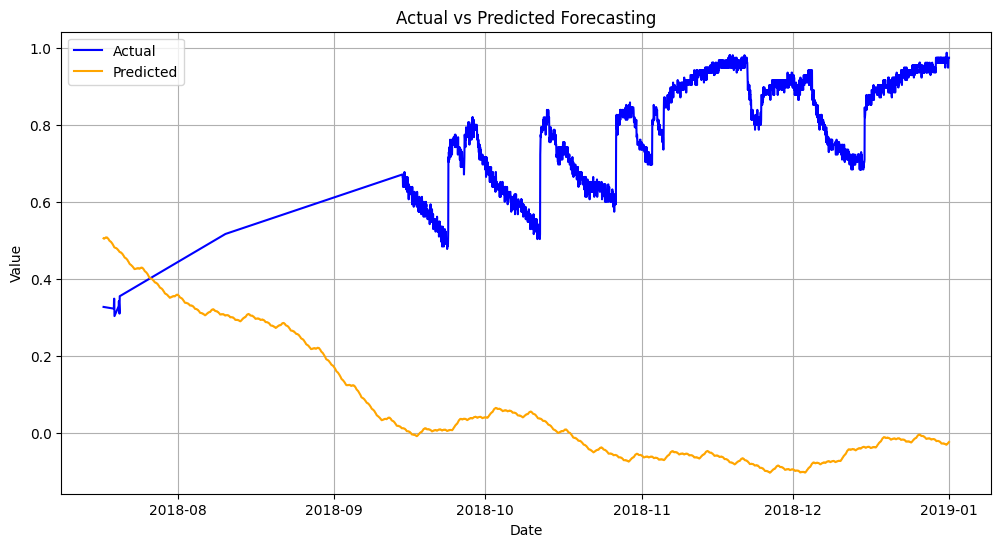

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['ds'], comparison_df['y'], label='Actual', color='blue')
plt.plot(comparison_df['ds'], comparison_df['yhat_y'], label='Predicted', color='orange')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Forecasting')
plt.legend()
plt.grid()
plt.show()